<a href="https://colab.research.google.com/github/sbantakal/Machine-Learning-Course-Work/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generative Adversarial Network**

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

**Loading MNIST Dataset**

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of sub-processes for data loading
num_workers = 0

# number of samples per batch  (ideal number is between 32 and 128, so i have taken 64)
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()


# get the training datasets
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Visualize the Training Data**

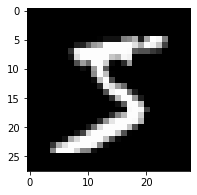

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

**Generative Adversarial Network**
```
A generative adversarial network consists of two adversarial neural networks, a discriminator and a generator.

We will be defining them in the following order: -
a.	Discriminator 
b.	Generator

Discriminator Network

The discriminator network is pretty typical linear classifier.To make the network into a universal function approximator, we will need at least one hidden layer. And these hidden layers have one key attribute;all the hidden layers will have a Leaky ReLu activation function applied to their outputs.

a.	Leaky ReLu
Each neuron in the hidden layers compute a dot product and add a bias value before outputting the value to the neuron in the next layer, this mathematical computation is linear in nature. These linear outputs ensure that the entire neural network to behave linearly. However, this is problematic when the dataset such as MNIST dataset on which the network is being trained on is nonlinear. 

Activation functions such as ReLu and Leaky ReLu are used to add non-linearity to network. They are placed directly after the hidden layers, since these mathematical functions are nonlinear in nature, they overall output is nonlinear. One of the most prominent activation functions used in today’s neural network is the ReLu activation function, which basically calculates max between 0 and the neuron output. But, firstly since the ReLu function is not continuously differentiable (x=0 being the breaking point) and more significantly, since ReLu sets all negative values to 0, neuron that arrive at large negative values get stuck at 0 (as gradient at 0 is 0), leading to the dying ReLu problem.

In order to sidestep this conundrum, Leaky ReLu has been used in this implementation, which is quite similar to ReLu, however as it permits a small non-zero outputs to pass through it, thus, allowing gradients to flow backwards through the layer unimpeded. The leakage factor was set to 0.2 in the implementation.

b.	Sigmoid Activation
To realize a more numerically stable loss function on the outputs, as we require the discriminator output to be either 0 or 1, indicating whether the image is legit or a counterfeit, we use BCEWithLogitsLoss function, which combines a sigmoid activation function and binary cross entropy loss in one function. Therefore, our final output layer will not have any activation function applied to it.
```



In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out


```
The generator network is almost exactly similar to the discriminator network, except that tanh function is used for the activation of the hidden layers.

Tanh Activation

The tanh activation function scales the output between -1 and 1 instead of 0 and 1. The generator network was found to perform at it its best with tanh activation function in the output layer.

The output values should be comparable to input pixel values, which are read in as normalized values that are between 0 and 1. Therefore, we need to scale our real input images to have pixel values between -1 and 1 during the training of the discriminator.
```




In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

**Defining the Model HyperParameters**

In [6]:
# Discriminator Hyper Parameters

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator Hyper Parameters

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

**Building the Complete Network**

In [7]:
# instantiate Discriminator and Generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check 
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


**Calculating Discriminator and Generator Losses**

```
Discriminator Loss

The discriminator loss is computed as the total sum of the loss for real and fake images, i.e., d_loss=d_realloss+d_fakeloss, since we need require the discriminator to output 1 for real images and 0 for fake images, we need a loss that reflects the same. 

The losses will be binary cross entropy loss with logits, which are obtained using BCEWithLogitsLoss. This combines a sigmoid activation function and and binary cross entropy loss in one function. For the real images, we want D(real_images) = 1. That is, we want the discriminator to classify the real images with a label = 1, indicating that these are real. 
To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9. To achieve this, the parameter smooth has been used; if True, then smoothen the labels. In PyTorch, this looks like labels = torch.ones(size) * 0.9. The discriminator loss for the fake data is similar, as we require D(fake_images) = 0, where the fake images are the generator output, i.e., fake_images = G(z).

Generator Loss

The generator loss looks fairly similar only with flipped labels. As the generator's goal is to get D(fake_images) = 1. In this case, the labels are flipped to represent that the generator is trying to trick the discriminator into thinking that the images it generates (fakes) are legit.

```



In [8]:
# Calculate Losses

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

**Optimizer**

The generator and discriminator variables are required to update separately, two separate Adam optimizers are initialized with a learning rate of 0.002.

In [9]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

**Training**

The training will involve alternating between training the discriminator and the generator. The functions for real loss and fake loss are used to help determine the discriminator losses.

The discriminator training involves the following steps: -
1.	Compute the discriminator loss on real, training images.
2.	Generate fake images.
3.	Compute the discriminator loss on fake, generated images.
4.	Add up real and fake loss.
5.	Perform backpropagation and an optimization step to update the discriminator's weights.

The generator training involves the following steps: -
1.	Generate fake images.
2.	Compute the discriminator loss on fake images, using flipped labels.
3.	Perform backpropagation and an optimization step to update the generator's weights.


**Saving Samples**

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [10]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3865 | g_loss: 0.6840
Epoch [    1/  100] | d_loss: 1.2663 | g_loss: 1.3019
Epoch [    1/  100] | d_loss: 1.5247 | g_loss: 0.7073
Epoch [    2/  100] | d_loss: 1.6494 | g_loss: 0.3892
Epoch [    2/  100] | d_loss: 1.1420 | g_loss: 1.1974
Epoch [    2/  100] | d_loss: 1.3366 | g_loss: 1.0953
Epoch [    3/  100] | d_loss: 1.2279 | g_loss: 1.1342
Epoch [    3/  100] | d_loss: 1.1961 | g_loss: 1.1780
Epoch [    3/  100] | d_loss: 1.0724 | g_loss: 1.1244
Epoch [    4/  100] | d_loss: 1.2439 | g_loss: 1.5764
Epoch [    4/  100] | d_loss: 1.3903 | g_loss: 1.0835
Epoch [    4/  100] | d_loss: 1.2318 | g_loss: 0.9685
Epoch [    5/  100] | d_loss: 1.1371 | g_loss: 1.0022
Epoch [    5/  100] | d_loss: 1.0476 | g_loss: 1.2278
Epoch [    5/  100] | d_loss: 1.0734 | g_loss: 2.1282
Epoch [    6/  100] | d_loss: 1.0517 | g_loss: 1.8200
Epoch [    6/  100] | d_loss: 1.1306 | g_loss: 1.7442
Epoch [    6/  100] | d_loss: 1.1319 | g_loss: 1.3553
Epoch [    7/  100] | d_loss

**Training Loss Plot**

Below is a plot the training losses for the generator and discriminator, recorded after each epoch.

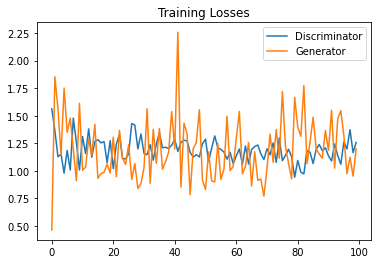

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

**Generator samples from training**

Sample images saved during training.

In [13]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [15]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

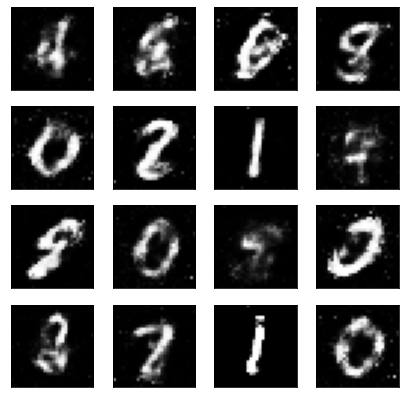

In [16]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

**Generated images as the network was training, every 10 epochs.**

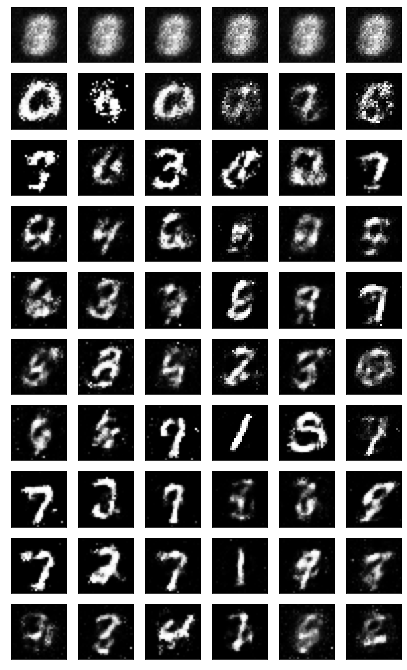

In [17]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

 **Sampling from the generator** 

We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector  𝑧  and we'll get new samples!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


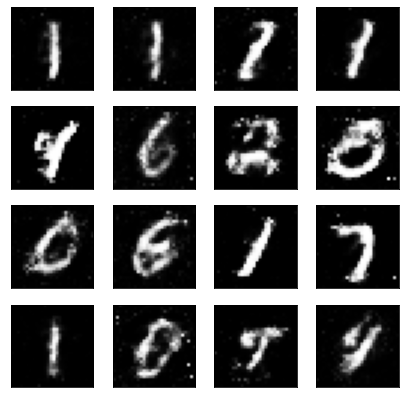

In [18]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])